('For n_clusters =', 2, 'The average silhouette_score is :', 0.4259054548427599)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.3921538401658974)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.38657038492923995)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.40968897740960597)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.40624742888819537)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.3954075823152745)


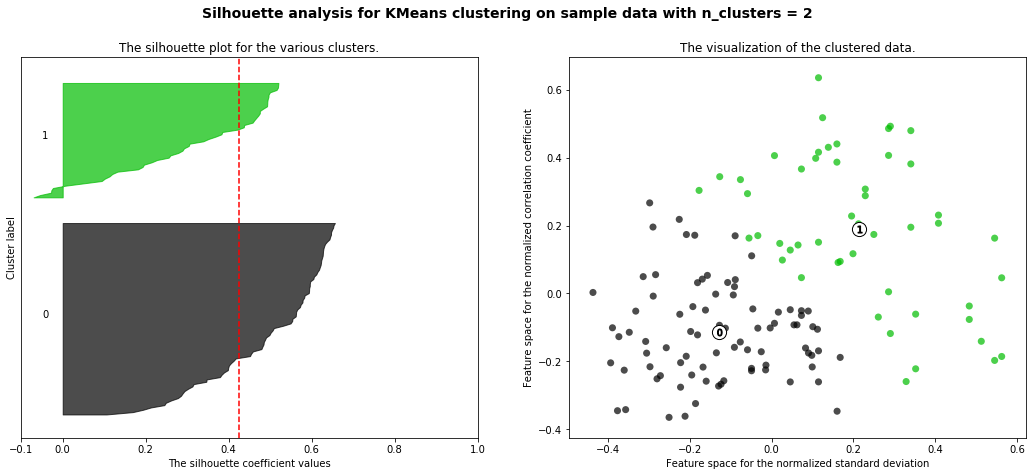

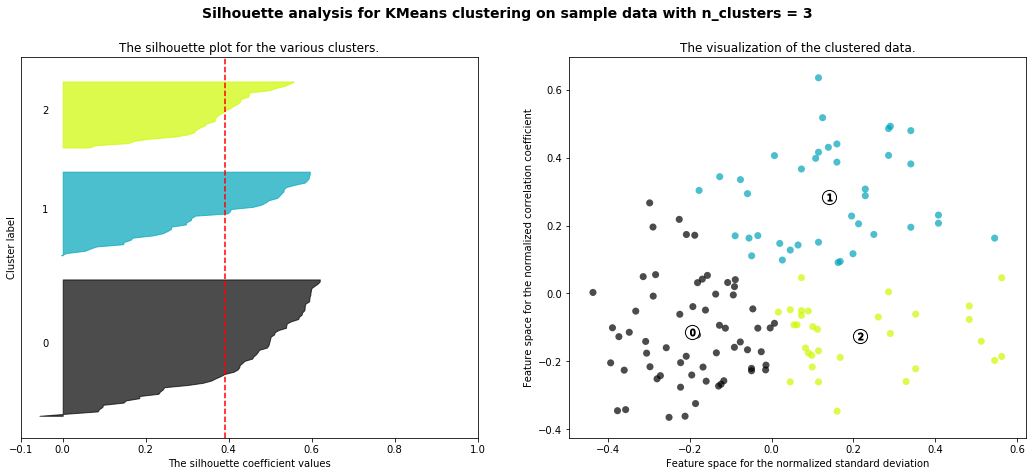

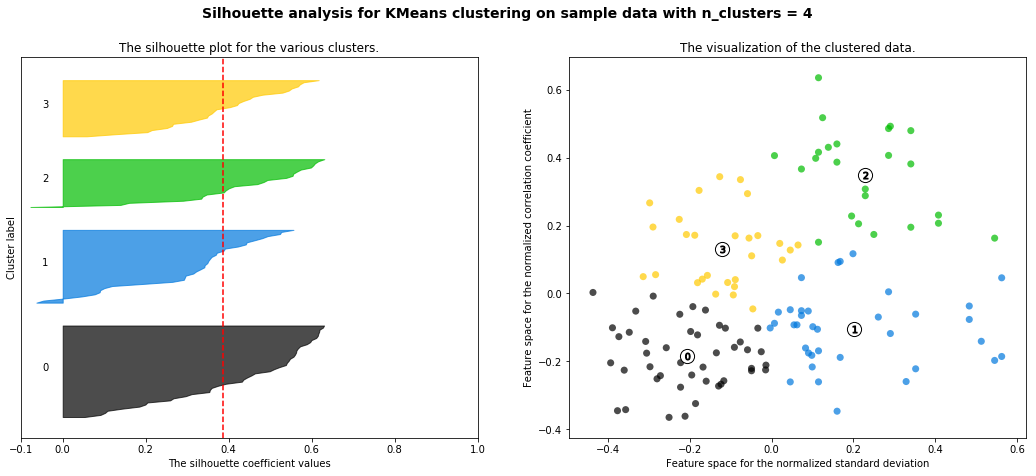

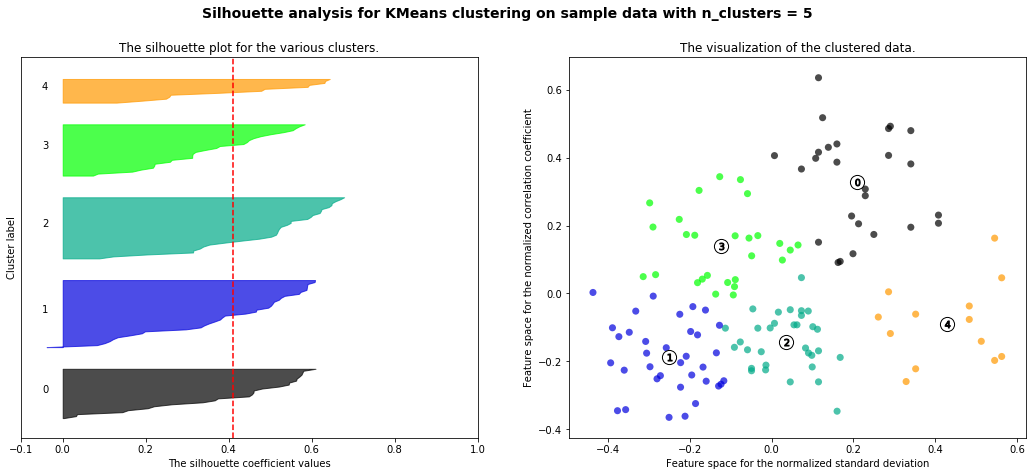

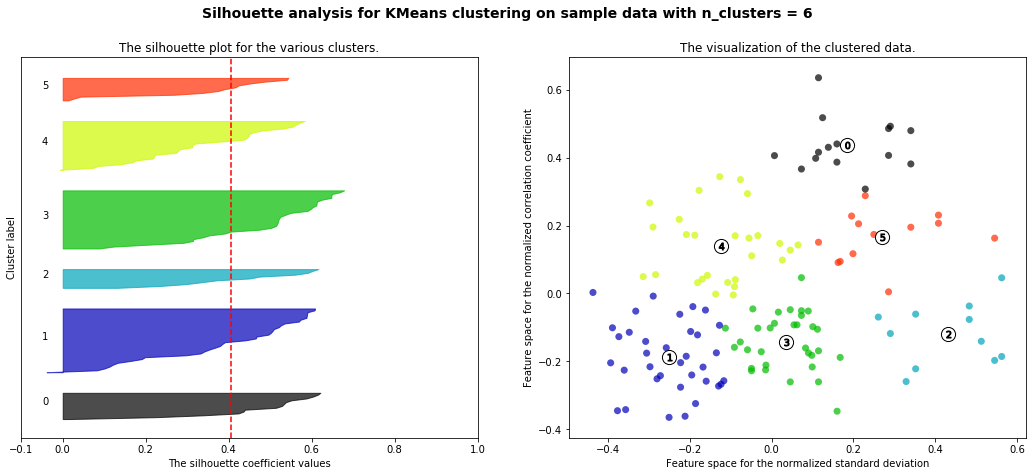

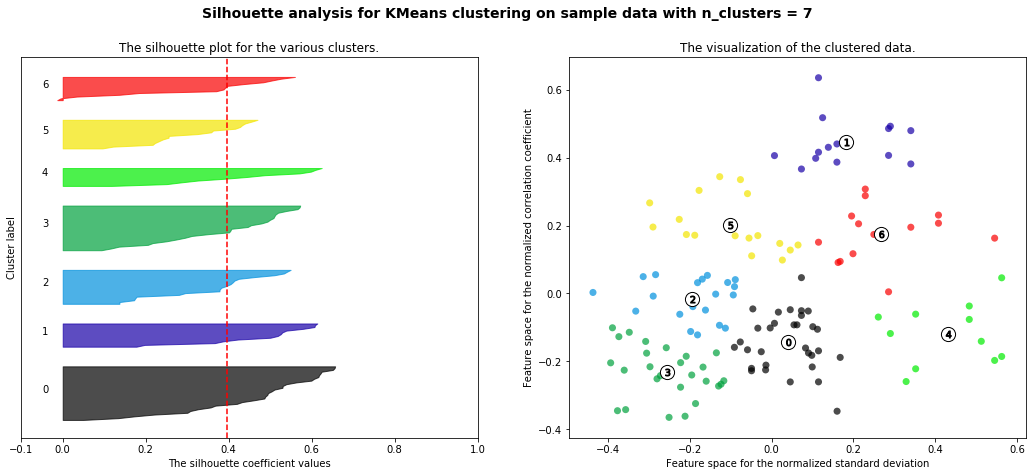

In [17]:
import re
import xml.etree.ElementTree
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


# util function
def cleantag(raw_html):
    cleanr = re.compile("<|>")
    cleantag = re.sub(cleanr, ' ', raw_html)
    return cleantag.strip()

post_e = xml.etree.ElementTree.parse('model/Posts.xml').getroot()
tag_date_tuple_list = []
for row in post_e.findall('row'):
    if row.get('PostTypeId') == '1':
        cleaned_tag_text = cleantag(row.get('Tags'))
        tags = cleaned_tag_text.split()
        date_str_list = row.get("CreationDate")[0:7].split('-')
        year = int(date_str_list[0])
        month = int(date_str_list[1])
        if 2011 <= year <= 2018:
            index = (year - 2011) * 2
            if int(month) > 6:
                index += 1
            date = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            date[index] = 1
            tag_date_tuple_list.extend([tag] + date for tag in tags)

df = pd.DataFrame(tag_date_tuple_list, columns=['tag',
                                                '2011-pre', '2011-post', '2012-pre', '2012-post', '2013-pre', '2013-post', '2014-pre', '2014-post',
                                                '2015-pre', '2015-post', '2016-pre', '2016-post', '2017-pre', '2017-post', '2018-pre', '2018-post']
                  )
df = df.groupby('tag').agg(np.sum)
tags_list = []
freqs_list = []
features_list = []
for tag, row in zip(df.index, df.values):
    if np.sum(row) >= 5:
        row = row * 1.0 / np.sum(row)
        tags_list.append(tag)
        freqs_list.append(row)
        std = np.std(row, ddof=1)
        cor = np.corrcoef(range(0, 16), row)[0][1]
        features_list.append([std, cor])
features_list = np.array(features_list)

# normalize
features_list[:, 0] = (features_list[:, 0] - np.mean(features_list[:, 0])) * 1.0 / (np.max(features_list[:, 0]) - np.min(features_list[:, 0]))
features_list[:, 1] = (features_list[:, 1] - np.mean(features_list[:, 1])) * 1.0 / (np.max(features_list[:, 1]) - np.min(features_list[:, 1]))
range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features_list) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(features_list)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features_list, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features_list, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2.scatter(features_list[:, 0], features_list[:, 1], marker='o', s=50, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the normalized standard deviation")
    ax2.set_ylabel("Feature space for the normalized correlation coefficient")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
